We want to show the Electric, Magnetic, and Pixel Intensity from Swarm B

In [37]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp

import scienceplots

plt.style.use(['science','no-latex'])
alt=110

In [38]:
time_array=(datetime(2022,12,19,14,4), datetime(2022,12,19,14,6))

In [39]:
#From documentation link
def requester(sc_collection, measurement, residual, sampling_step=None, **kwargs):
    try:
        request = SwarmRequest()
        request.set_collection(sc_collection)
        if residual == True:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                residuals=True,
                sampling_step=sampling_step,
            )
        else:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                sampling_step=sampling_step,
            )
        data = request.get_between(time_array[0], time_array[1], **kwargs) #sets to get data between the first and last value in the time tuple
        df = data.as_dataframe()
    except:
        df = []
    return df

In [40]:
def arrangement(time, array, shape):  # arranges B into a useable format for use later
    barranged = np.zeros((len(time), shape))
    # Re-arranges into proper (n x 3 ) matricies, ugly but works
    for j in range(len(time)):
        for k in range(shape):
            barranged[j][k] = array[j][k]
    return barranged

In [41]:
def unit_array(array):
    arraysum = np.sum(np.abs(array), axis=1)
    # Normalizes and finds unitary
    array_unit = array / arraysum[:, np.newaxis]  # normalizes
    return array_unit

In [42]:
#Lets do B first
ds = requester( 
    "SW_OPER_MAGB_HR_1B", #Mag B, high resolution, 50Hz B (Magnetic field)
    "B_NEC", #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) 
print(ds)
BNEC=ds["B_NEC_res_CHAOS"]
Btime = BNEC.index.to_numpy()
BNEC = arrangement(Btime, ds["B_NEC_res_CHAOS"], 3)




[]


TypeError: list indices must be integers or slices, not str

In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def quaternion_inverse_scipy(q):
    # Ensure q is a numpy array
    q = np.asarray(q)
    
    # Create a Rotation object from the quaternion
    rotation = R.from_quat(q)  # Note: scipy uses [x, y, z, w] format
    
    # Compute the inverse rotation
    inverse_rotation = rotation.inv()
    
    
    return inverse_rotation

In [ ]:

def find_closest_indices(times1, times2):
    # Convert to numpy arrays
    times1 = np.array(times1)
    times2 = np.array(times2)
    
    # Compute the differences between each time in times1 and all times in times2
    # Resulting in a 2D array where each row contains the absolute differences for one time in times1
    differences = np.abs(times1[:, None] - times2)
    
    # Find the index of the minimum difference for each time in times1
    closest_indices = np.argmin(differences, axis=1)
    
    return closest_indices

In [ ]:
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
import geopack.geopack as gp
def footprint(time, latitude, longitude, altitude, alt,vsw= [-400,0,0]):
    """
    time, datetime, time for magnetic data for footprint
    vsw velocity of solar wind, tuple of x,y,z
    longitude of satellite in degrees
    latitude of satellite in degrees
    altitude of satellite in km from centre of earth (should be above ~6371)
    THIS CODE ONLY Works in the NOrthern hemisphere

    """
    def cubic(t, a, b, c, d):
            return a*t**3 + b*t**2 + c*t + d
    def x(t, params_x):
        return cubic(t, *params_x)

    def y(t, params_y):
        return cubic(t, *params_y)

    def z(t, params_z):
        return cubic(t, *params_z)
    def radius(t, params_x, params_y, params_z):
        return np.sqrt(x(t, params_x)**2 + y(t, params_y)**2 + z(t, params_z)**2)
    
    def curve_fit_func(xx,yy,zz, differencealt):
        
        r = np.linspace(1, 1.5, 100000)# construct an array of radiuses from 1-1.5

        radius_data=np.sqrt(xx**2+yy**2+zz**2)

        params_x, _ = curve_fit(cubic, radius_data, xx) #Constructs fits on the traces inward since the spatial resolution produced by geopack is limited.
        params_y, _ = curve_fit(cubic, radius_data, yy)
        params_z, _ = curve_fit(cubic, radius_data, zz)

        

        index_closest=np.argmin(np.abs(radius(r, params_x, params_y, params_z)-(alt-differencealt+6371)/6371))#Find the index that produces the closest radius to the altitude

        return x(r[index_closest],params_x ),y(r[index_closest],params_y ),z(r[index_closest],params_z )
    
    t1 = time
    t0 = datetime(1970,1,1) #epoch
    ut = (t1-t0).total_seconds()
    lat_sat=np.deg2rad(latitude)
    lon_sat=np.deg2rad(longitude) #converts to radii
    gp.recalc(ut)
    r, theta= gp.geodgeo(altitude,lat_sat,1) #this r accounts for earths oblateness, so we need to find the difference between my 6371 assumption and the real value and account for that
    differencearray= (altitude+6371)-r
    x_gc,y_gc,z_gc = gp.sphcar((r)/6371,theta,lon_sat,1)  #spherical to cartesian
    

    x_gsm, y_gsm, z_gsm = gp.geogsm(x_gc,y_gc,z_gc, 1) #cartesian to gsm

    x_foot,y_foot,z_foot=np.zeros(len(x_gsm)), np.zeros(len(y_gsm)), np.zeros(len(z_gsm)) #initalize an array
    for index in range(len(x_gsm)):
        x_foot_int, y_foot_int, z_foot_int, xx, _,zz = gp.trace(x_gsm[index], y_gsm[index], z_gsm[index], dir=1,rlim=2, maxloop=3000 ) #traces each set of lat,lon,alt outward
        _, _, _, xx2,yy2,zz2 = gp.trace(x_foot_int, y_foot_int, z_foot_int, dir=-1,rlim=100, maxloop=1000 )#Traces inward

        x_foot[index],y_foot[index],z_foot[index] = curve_fit_func(xx2,yy2,zz2, differencearray[index])


            

    x_done, y_done, z_done = gp.geogsm(x_foot, y_foot, z_foot, -1)

    alt_sat_done, lat_sat_done,lon_sat_done = np.zeros(len(x_done)), np.zeros(len(x_done)), np.zeros(len(x_done))
    for index in range(len(x_done)):
        
        r_done,theta_done,lon_sat_done[index]= gp.sphcar(x_done[index], y_done[index], z_done[index],-1)

        alt_sat_done[index], lat_sat_done[index]= gp.geodgeo(r_done*6371,theta_done,-1) #TODO check if this is right

    print(alt_sat_done, 'altitude derived from fit')

    if np.any(np.abs(alt_sat_done - alt) > 5):
        raise Exception("One or more values in the footprinting are greater than 5km away from the specified alt. Contact owner for a fix, not your fault")
    print(np.rad2deg(lon_sat_done)-360,np.rad2deg(lat_sat_done) , 'lat and lon' )
    sat_lla=np.array([ np.rad2deg(lat_sat_done), np.rad2deg(lon_sat_done)-360,  alt_sat_done])
    return sat_lla

In [ ]:
measurements_E = [
        "VsatN",
        "VsatE",
        "VsatC",
        "Evx",
        "Evy",
        "Evz",
        "Vixv",
        "Viy",
        "Viz",
        "Quality_flags",
    ]
ds = requester( 
    "SW_EXPT_EFIB_TCT16", #Mag B, high resolution, 50Hz B (Magnetic field)
    measurements_E, #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) 
print(ds)
dsB = requester( 
    'SW_OPER_MAGB_HR_1B', #Mag B, high resolution, 50Hz B (Magnetic field)
    ["q_NEC_CRF"], #Magnetic field in NEC coordinates
    False, 
    asynchronous=False,
    show_progress=False)

latitude, longitude, altitude = dsB['Latitude'].to_numpy(), dsB['Longitude'].to_numpy(),  (dsB["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data


                                       Viy        Evy        VsatN  \
Timestamp                                                            
2022-12-19 14:04:00.006750107 -1615.462402 -43.889839 -7580.783203   
2022-12-19 14:04:00.068749905 -1580.580078 -44.201260 -7580.793457   
2022-12-19 14:04:00.131750107 -1607.080078 -50.670647 -7580.804199   
2022-12-19 14:04:00.193749905 -1654.593506 -45.661617 -7580.814453   
2022-12-19 14:04:00.256750107 -1748.560547 -47.468952 -7580.824707   
...                                    ...        ...          ...   
2022-12-19 14:05:59.693749905    27.865946 -17.630184 -7594.200195   
2022-12-19 14:05:59.756750107    61.090351 -18.456339 -7594.205078   
2022-12-19 14:05:59.818749905    89.335548 -17.988640 -7594.209473   
2022-12-19 14:05:59.881750107    91.037277 -19.799648 -7594.214355   
2022-12-19 14:05:59.943749905    27.486427 -18.056873 -7594.218750   

                                    VsatE   Latitude       Evz      VsatC  \
Timestamp   

In [ ]:
sat_lla_B=footprint(time_array[0], latitude, longitude, altitude, alt, vsw=[-345,12,-12])


[110.13994053 110.13959817 110.13925048 ... 110.26111073 110.26070466
 110.26029716] altitude derived from fit
[-117.80703619 -117.80682449 -117.80661295 ... -116.93112839 -116.9310317
 -116.93093494] [65.89160447 65.89037831 65.88915215 ... 58.55720458 58.55598607
 58.55476755] lat and lon


In [ ]:
print(sat_lla_B)

[[  65.89160447   65.89037831   65.88915215 ...   58.55720458
    58.55598607   58.55476755]
 [-117.80703619 -117.80682449 -117.80661295 ... -116.93112839
  -116.9310317  -116.93093494]
 [ 110.13994053  110.13959817  110.13925048 ...  110.26111073
   110.26070466  110.26029716]]


In [ ]:
indicies=find_closest_indices(ds.index, dsB.index)
quatnecrf=dsB["q_NEC_CRF"].to_numpy()[indicies]
quaternions = []
Esat=np.array([ds["Evx"] , ds["Evy"], ds["Evz"]]).T
vsat=np.array([ds["Vixv"] , ds["Viy"], ds["Viz"]]).T
Etime = ds.index
ENEC=[]
VNEC=[]
for i in range(len(quatnecrf)):
    inverse_quat = quaternion_inverse_scipy(dsB["q_NEC_CRF"].to_numpy()[indicies][i])
    rot_NEC_V= inverse_quat.apply(Esat[i])
    ENEC.append(rot_NEC_V)

    rot_NEC_V= inverse_quat.apply(vsat[i])
    VNEC.append(rot_NEC_V)

ENEC=np.array(ENEC)
VNEC=np.array(VNEC)


Now for the hard part, the pixel intensity
Since the satellite as seen in figure 1 passes through the arc pretty fast, we should increase the resolution of the pixel intensity by super imposing 

Lets define the imager

In [ ]:
latitude, longitude, altitude = ds['Latitude'].to_numpy(), ds['Longitude'].to_numpy(),  (ds["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data

alt=110

In [ ]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=110, time_range=time_array, colors='r')


Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


In [ ]:

sat_lla_E=footprint(time_array[0],latitude, longitude, altitude, alt, vsw=[-345,12,-12])

conjunction_obj = asilib.Conjunction(asi, (np.array(Etime), sat_lla_E.T))

[110.1242496  110.12318887 110.12210826 ... 110.25085078 110.24956823
 110.24830892] altitude derived from fit
[-117.75937134 -117.75871749 -117.75805331 ... -116.88473604 -116.8844201
 -116.88413489] [65.94932781 65.94552522 65.94166834 ... 58.62185066 58.6180074
 58.61424108] lat and lon


In [ ]:
#Now lets 

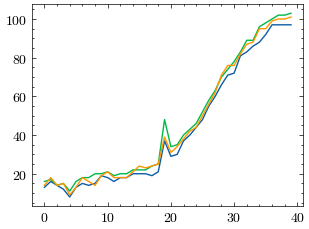

In [ ]:
sat_azimuth_elevation, sat_azel_pixels = conjunction_obj.map_azel()
area_intensity = conjunction_obj.intensity()
area_mask = conjunction_obj.equal_area(box=(10,10))
# Need to change masked NaNs to 0s so we can plot the rectangular area contours.
area_mask[np.where(np.isnan(area_mask))] = 0
plt.plot(area_intensity) #This gives us a resolution of 3Hz.


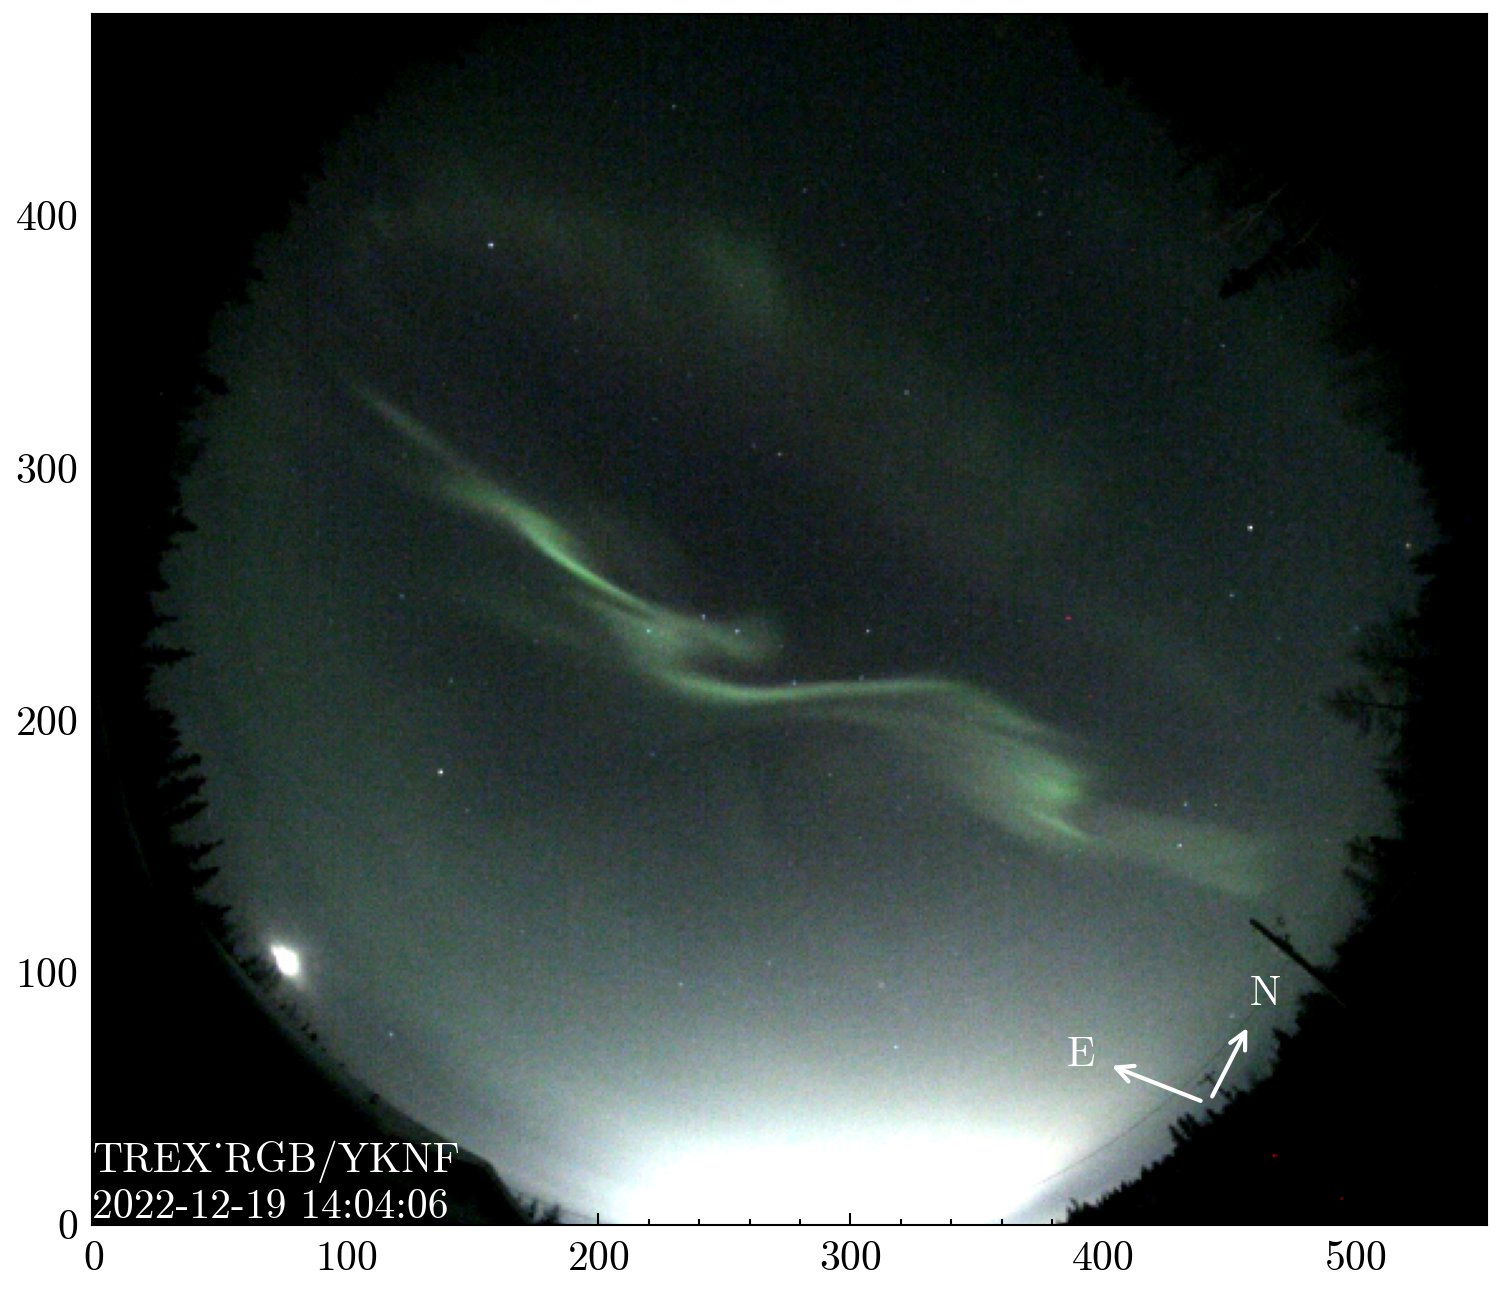

In [ ]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
asi_single=asilib.asi.trex_rgb(location_code='yknf', alt=110, time=datetime(2022,12,19,14,4,5), colors='rgb')

ax, im_good = asi_single.plot_fisheye(ax=ax)


[[-117.67111  -117.67111  -117.67111  ... -117.67111  -117.67111
  -117.67111 ]
 [-117.67111  -117.67111  -117.67111  ... -118.852844 -118.852844
  -118.852844]
 [-117.336914 -117.336914 -117.336914 ... -119.15723  -119.15723
  -119.15723 ]
 ...
 [-107.5318   -107.5318   -107.5318   ... -112.41608  -112.41608
  -112.41608 ]
 [-107.665924 -107.665924 -107.665924 ... -112.23334  -112.23334
  -112.23334 ]
 [-107.403625 -107.403625 -107.403625 ... -107.403625 -107.403625
  -107.403625]]


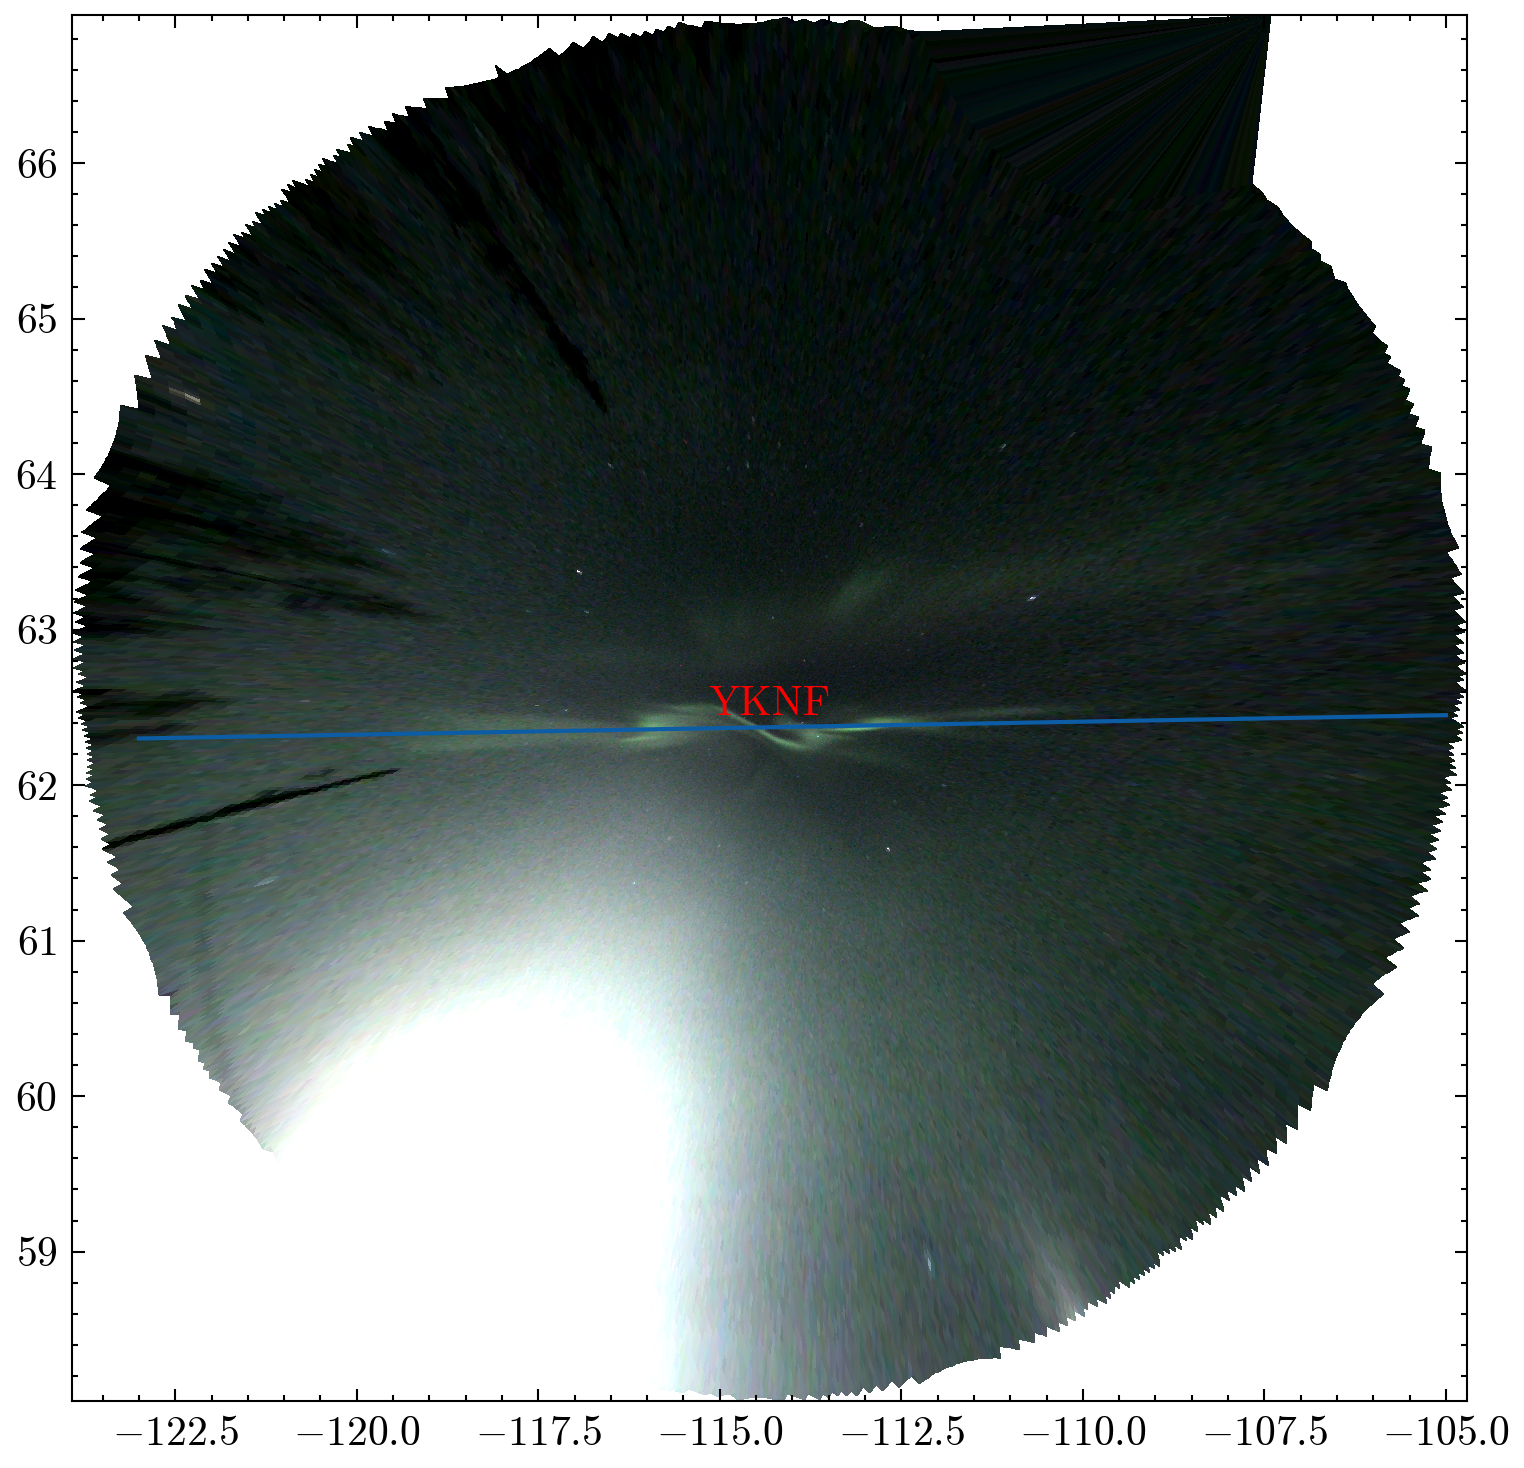

In [ ]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax, im_good = asi_single.plot_map(ax=ax)
coords=im_good.get_coordinates()
x_coords=coords[:,:,0]
y_coords=coords[:,:,1]
print(x_coords)
x = np.linspace(-123, -105, 200)
y= np.linspace(62.3, 62.45, 200)
plt.plot(x,y)


In [ ]:

R=6371.0+alt
# Convert degrees to radians
def deg2rad(deg):
    return deg * np.pi / 180.0

# Haversine formula to calculate distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    dlat = deg2rad(lat2 - lat1)
    dlon = deg2rad(lon2 - lon1)
    a = np.sin(dlat / 2)**2 + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# grid_lats, grid_lons: 2D arrays representing the latitude and longitude grid
# line_lats, line_lons: 1D arrays representing the latitude and longitude of the line

def find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons):
    closest_indices = []
    for lat, lon in zip(line_lats, line_lons):
        # Calculate the distance from the current line point to all grid points
        distances = haversine(grid_lats, grid_lons, lat, lon)
        
        # Find the index of the minimum distance
        min_index = np.unravel_index(np.argmin(distances), distances.shape)
        closest_indices.append(min_index)
    
    return closest_indices

# Example usage
grid_lats = y_coords
grid_lons = x_coords

line_lats = y
line_lons = x

closest_indices = find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons)


Downloaded 20221219_1404_yknf_rgb-08_full.h5.
Downloaded 20221219_1405_yknf_rgb-08_full.h5.
Downloaded rgb_skymap_yknf_20220913-%2B_v01.sav.
Downloaded rgb_skymap_yknf_20230114-%2B_v01.sav.



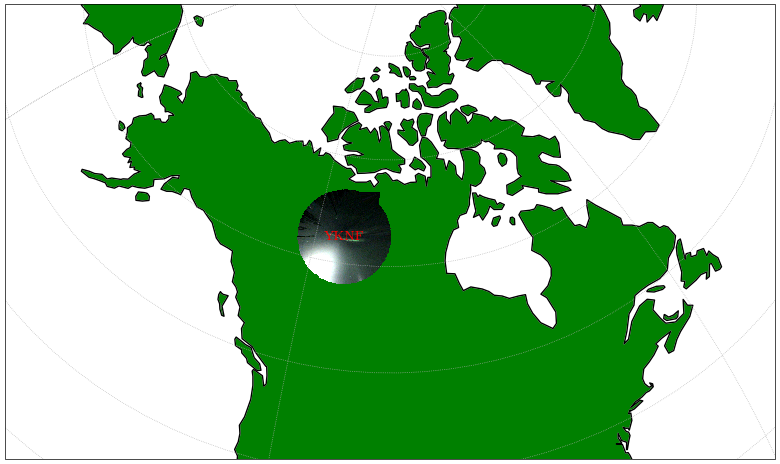

In [60]:

x_1 = np.linspace(-123, -105, 800)
y_1= np.linspace(62.3, 62.45, 800)

x_2 = np.linspace(-123, -105, 800)
y_2= np.linspace(62.5, 63.6, 800)

asi=asilib.asi.trex_rgb(location_code='yknf', alt=110, time_range=(time_array[0], time_array[-1]), redownload=True)

pixel_closest_sat = []
pixel_closest_sat_track = []
pixel_closest_1 = []
pixel_closest_2 =[]
time_ewo = []
times= []
lats = []
lons = []

movie_generator = asi.animate_map_gen()


for i, (time, image, _, im) in enumerate(movie_generator):

    indices = np.where((Etime >= np.datetime64(time)) & (Etime <= np.datetime64((time +timedelta(seconds=3)))))[0]
    coords=im.get_coordinates()
    grid_lons=coords[:,:,0]
    grid_lats=coords[:,:,1]


    closest_indices = np.transpose(find_closest_grid_points(grid_lats, grid_lons, sat_lla_E[0][indices], sat_lla_E[1][indices]))
    for j in range(len(closest_indices[0])):
        pixel_closest_sat.append(image[closest_indices[0][j], closest_indices[1][j] , 1])
        times.append(Etime.to_numpy()[indices[j]])
        lats.append(sat_lla_E[0][indices[j]])
        lons.append( sat_lla_E[1][indices[j]])

    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, y_1, x_1))
    temp_1=[]
    for j in range(len(closest_indices[0])):
        temp_1.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_1.append(temp_1)


    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, y_2, x_2))
    temp_2=[]
    for j in range(len(closest_indices[0])):
        temp_2.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_2.append(temp_2)
    closest_indices=np.transpose(find_closest_grid_points(grid_lats, grid_lons, sat_lla_E[0], sat_lla_E[1]))
    temp_3=[]
    for j in range(len(closest_indices[0])):
        temp_3.append(image[closest_indices[0][j], closest_indices[1][j], :])
    pixel_closest_sat_track.append(temp_3)
    time_ewo.append(time)

    if i==39:
        break #due to run error TODO


[457 457 457 ... 249 249 248]
40
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800


ValueError: cannot reshape array of size 96000 into shape (200,40,3)

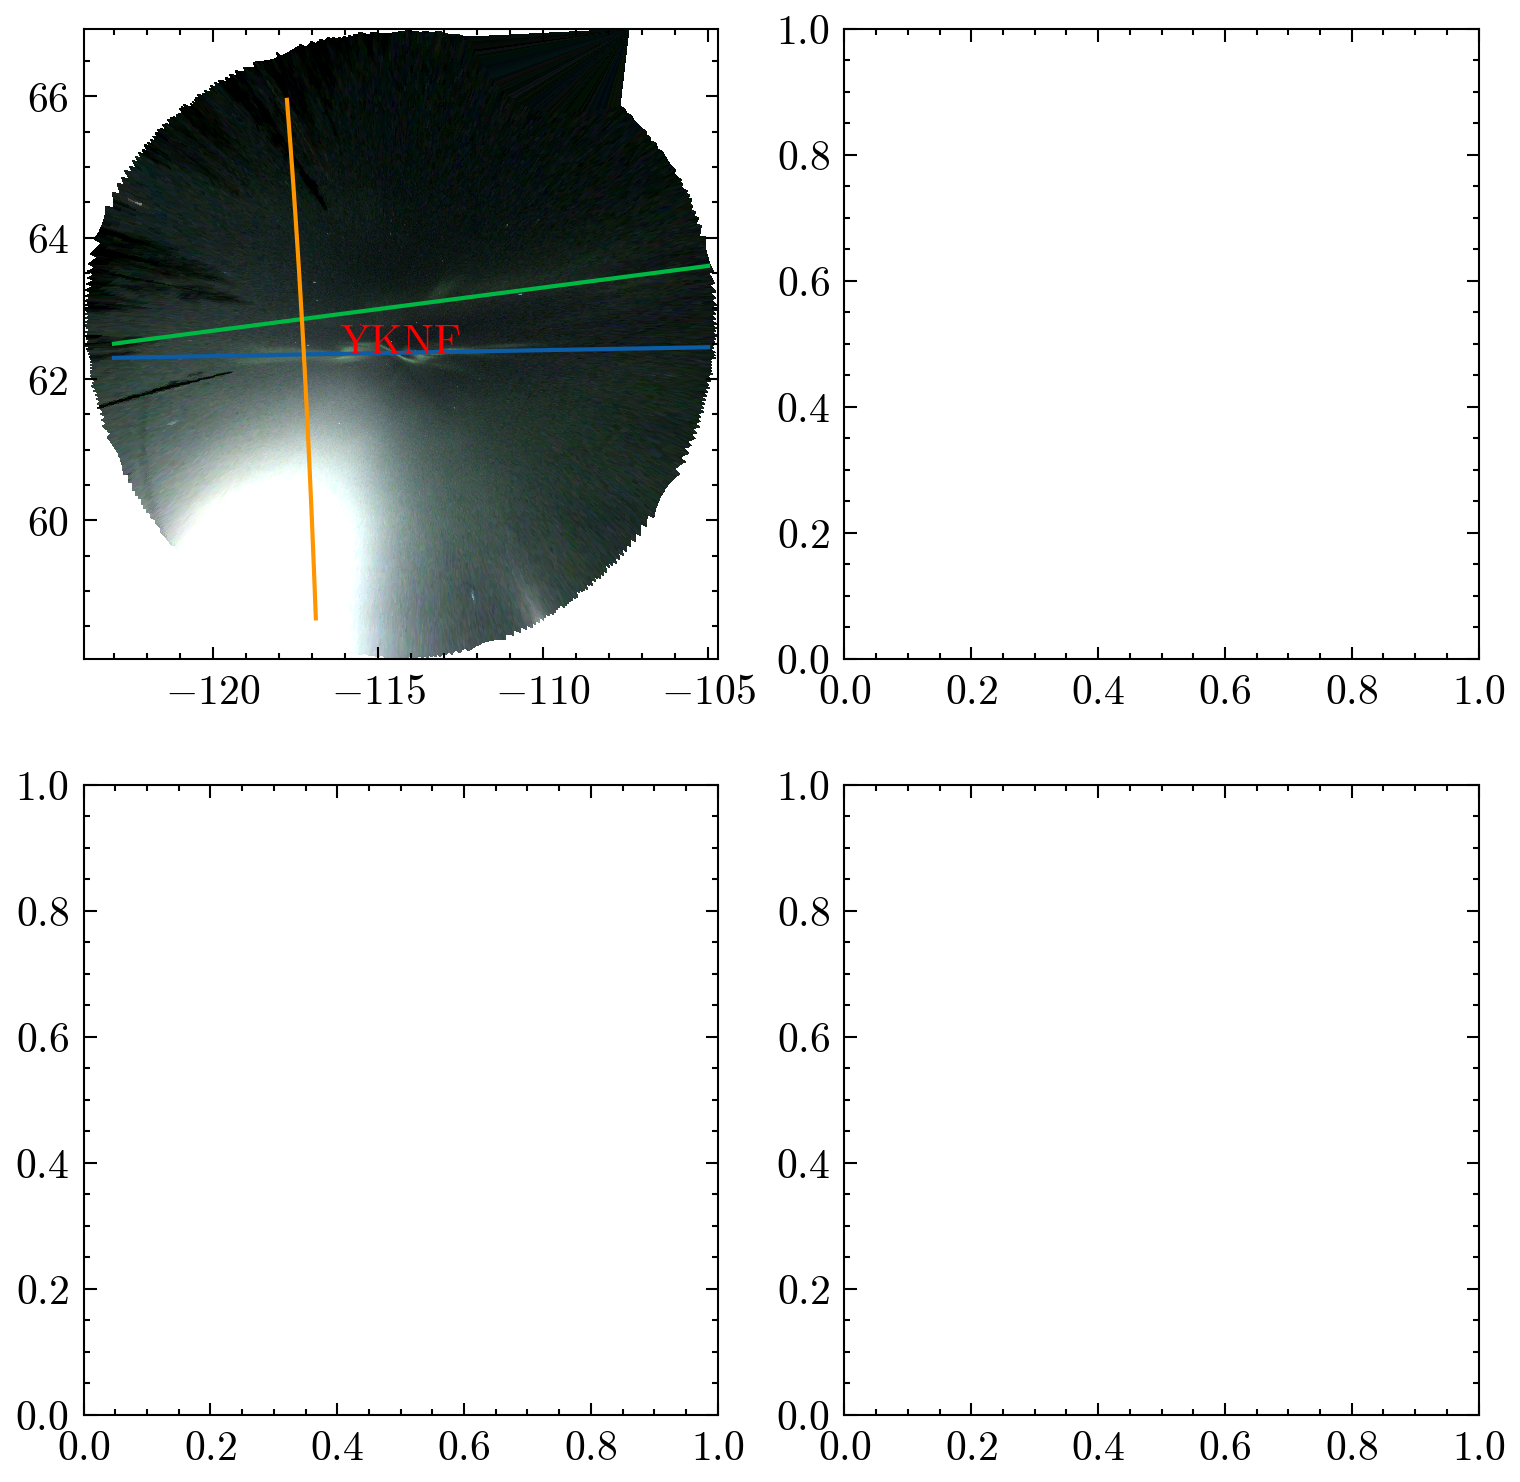

: 

In [61]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300, nrows=2, ncols=2) #show image of the track, and ewograms, then show the keograms of each line
axes, im_good = asi_single.plot_map(ax=ax[0][0])
print(closest_indices[:][1])



axes.plot(x_1,y_1)

axes.plot(x_2,y_2)
axes.plot(sat_lla_E[1], sat_lla_E[0]) #Ma
print(len(pixel_closest_1))

for i in range(len(pixel_closest_1)):
    print(len(pixel_closest_1[i]))


ax[0][1].pcolormesh(time_ewo, x_1, np.reshape(pixel_closest_1, (200,40,3) ), shading='gouraud')


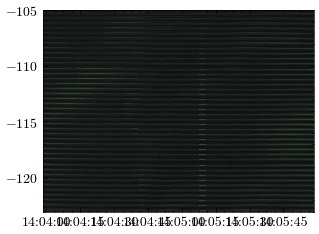

In [ ]:
plt.pcolormesh(time_ewo, x_1, np.reshape(pixel_closest_1, (200,40,3) ))

[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 16, 16, 16,

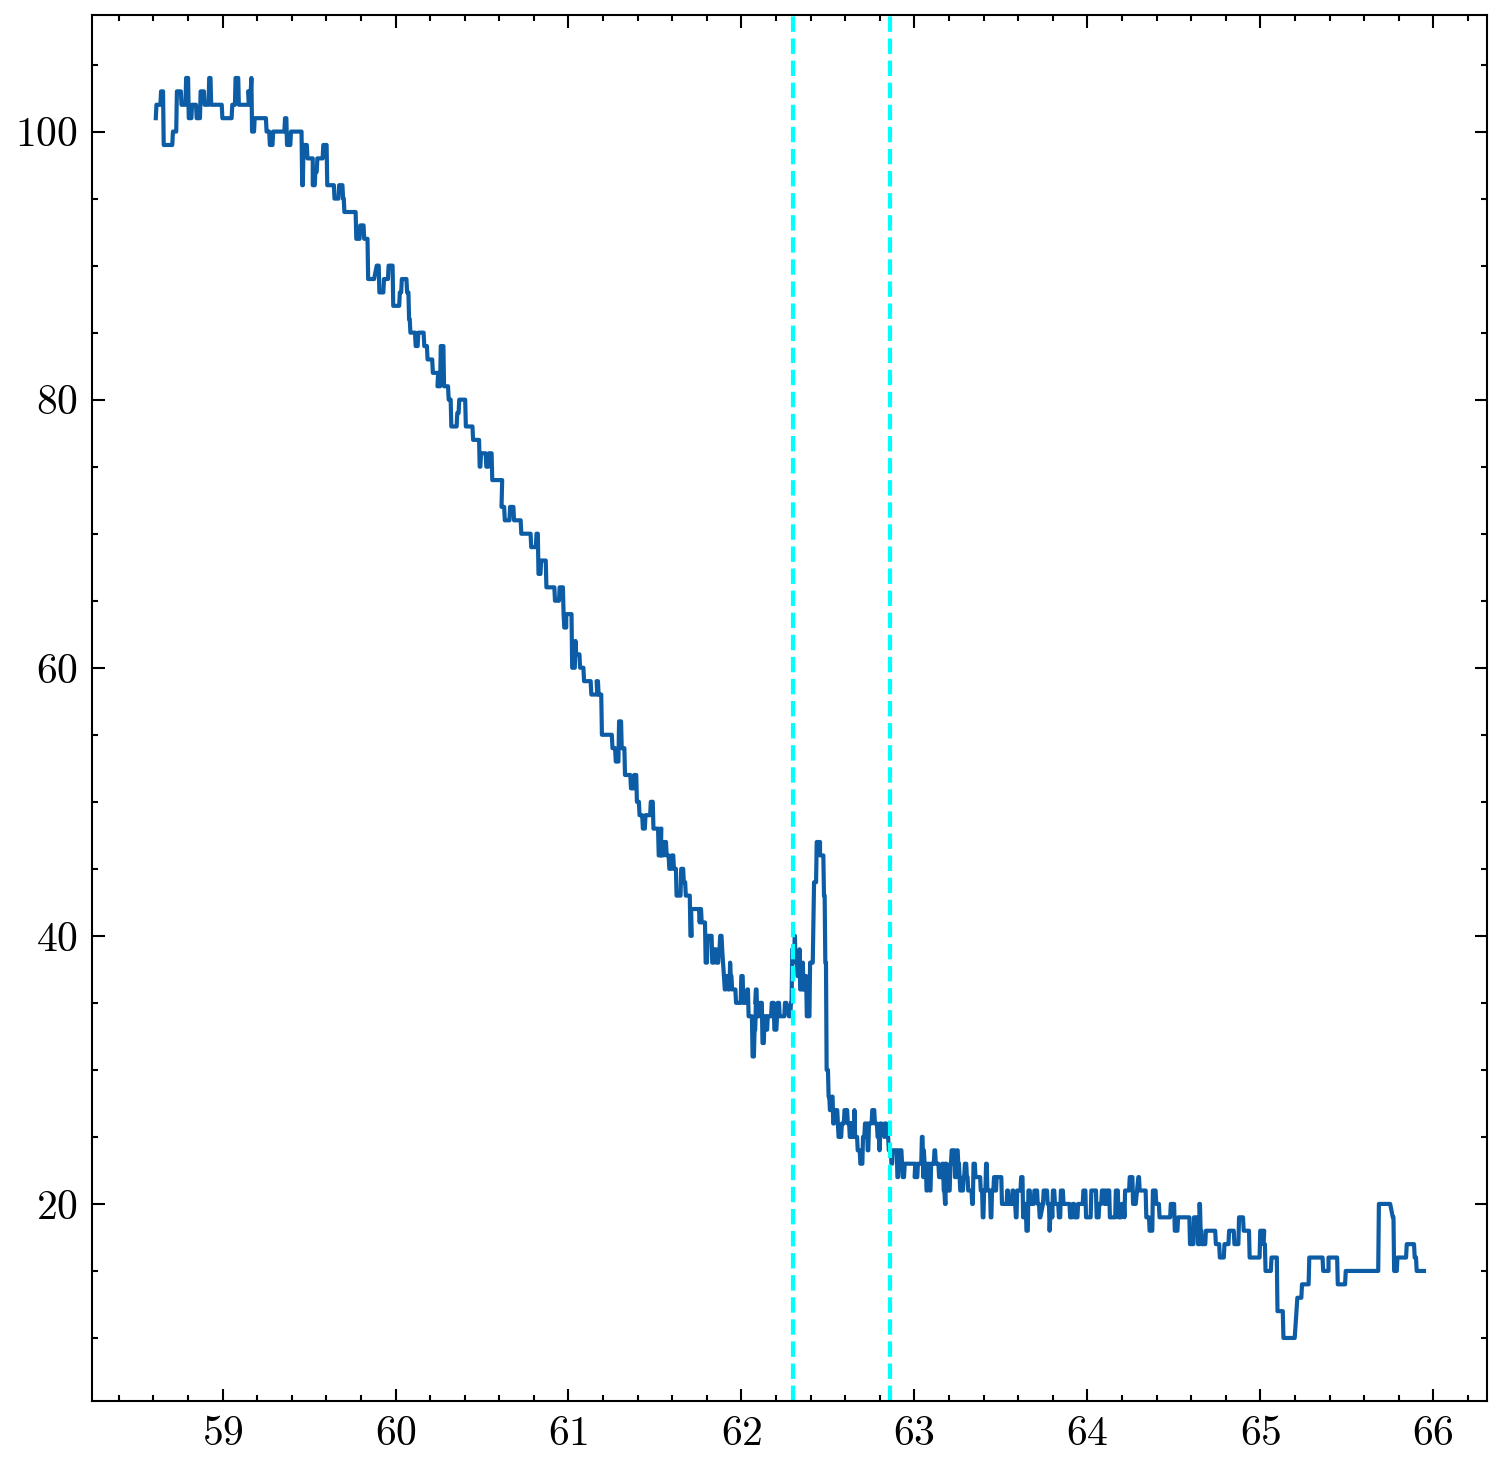

In [ ]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
pixel_chosen_array= pixel_closest_sat
print(pixel_chosen_array)
plt.plot(lats, pixel_chosen_array)
plt.axvline(62.86, color='cyan', linestyle='dashed')
plt.axvline(62.3, color='cyan', linestyle='dashed')

Now lets make an ewogram

In [ ]:

ax, im_good = asi_multiple.plot_keogram(ax=ax)

x_data = im.get_coordinates()[:, 0, 1]
y_data = im.get_coordinates()[:, 1, 1]


print(im_good.get_array()[:, 60, 0])

NameError: name 'asi_multiple' is not defined

In [ ]:
lat16 = sat_lla_E[0]
lat50 = sat_lla_B[0]

We want our plots to have lat verus data


(40, 3)



C:\Users\1101w\AppData\Local\Temp\ipykernel_23728\2921170443.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

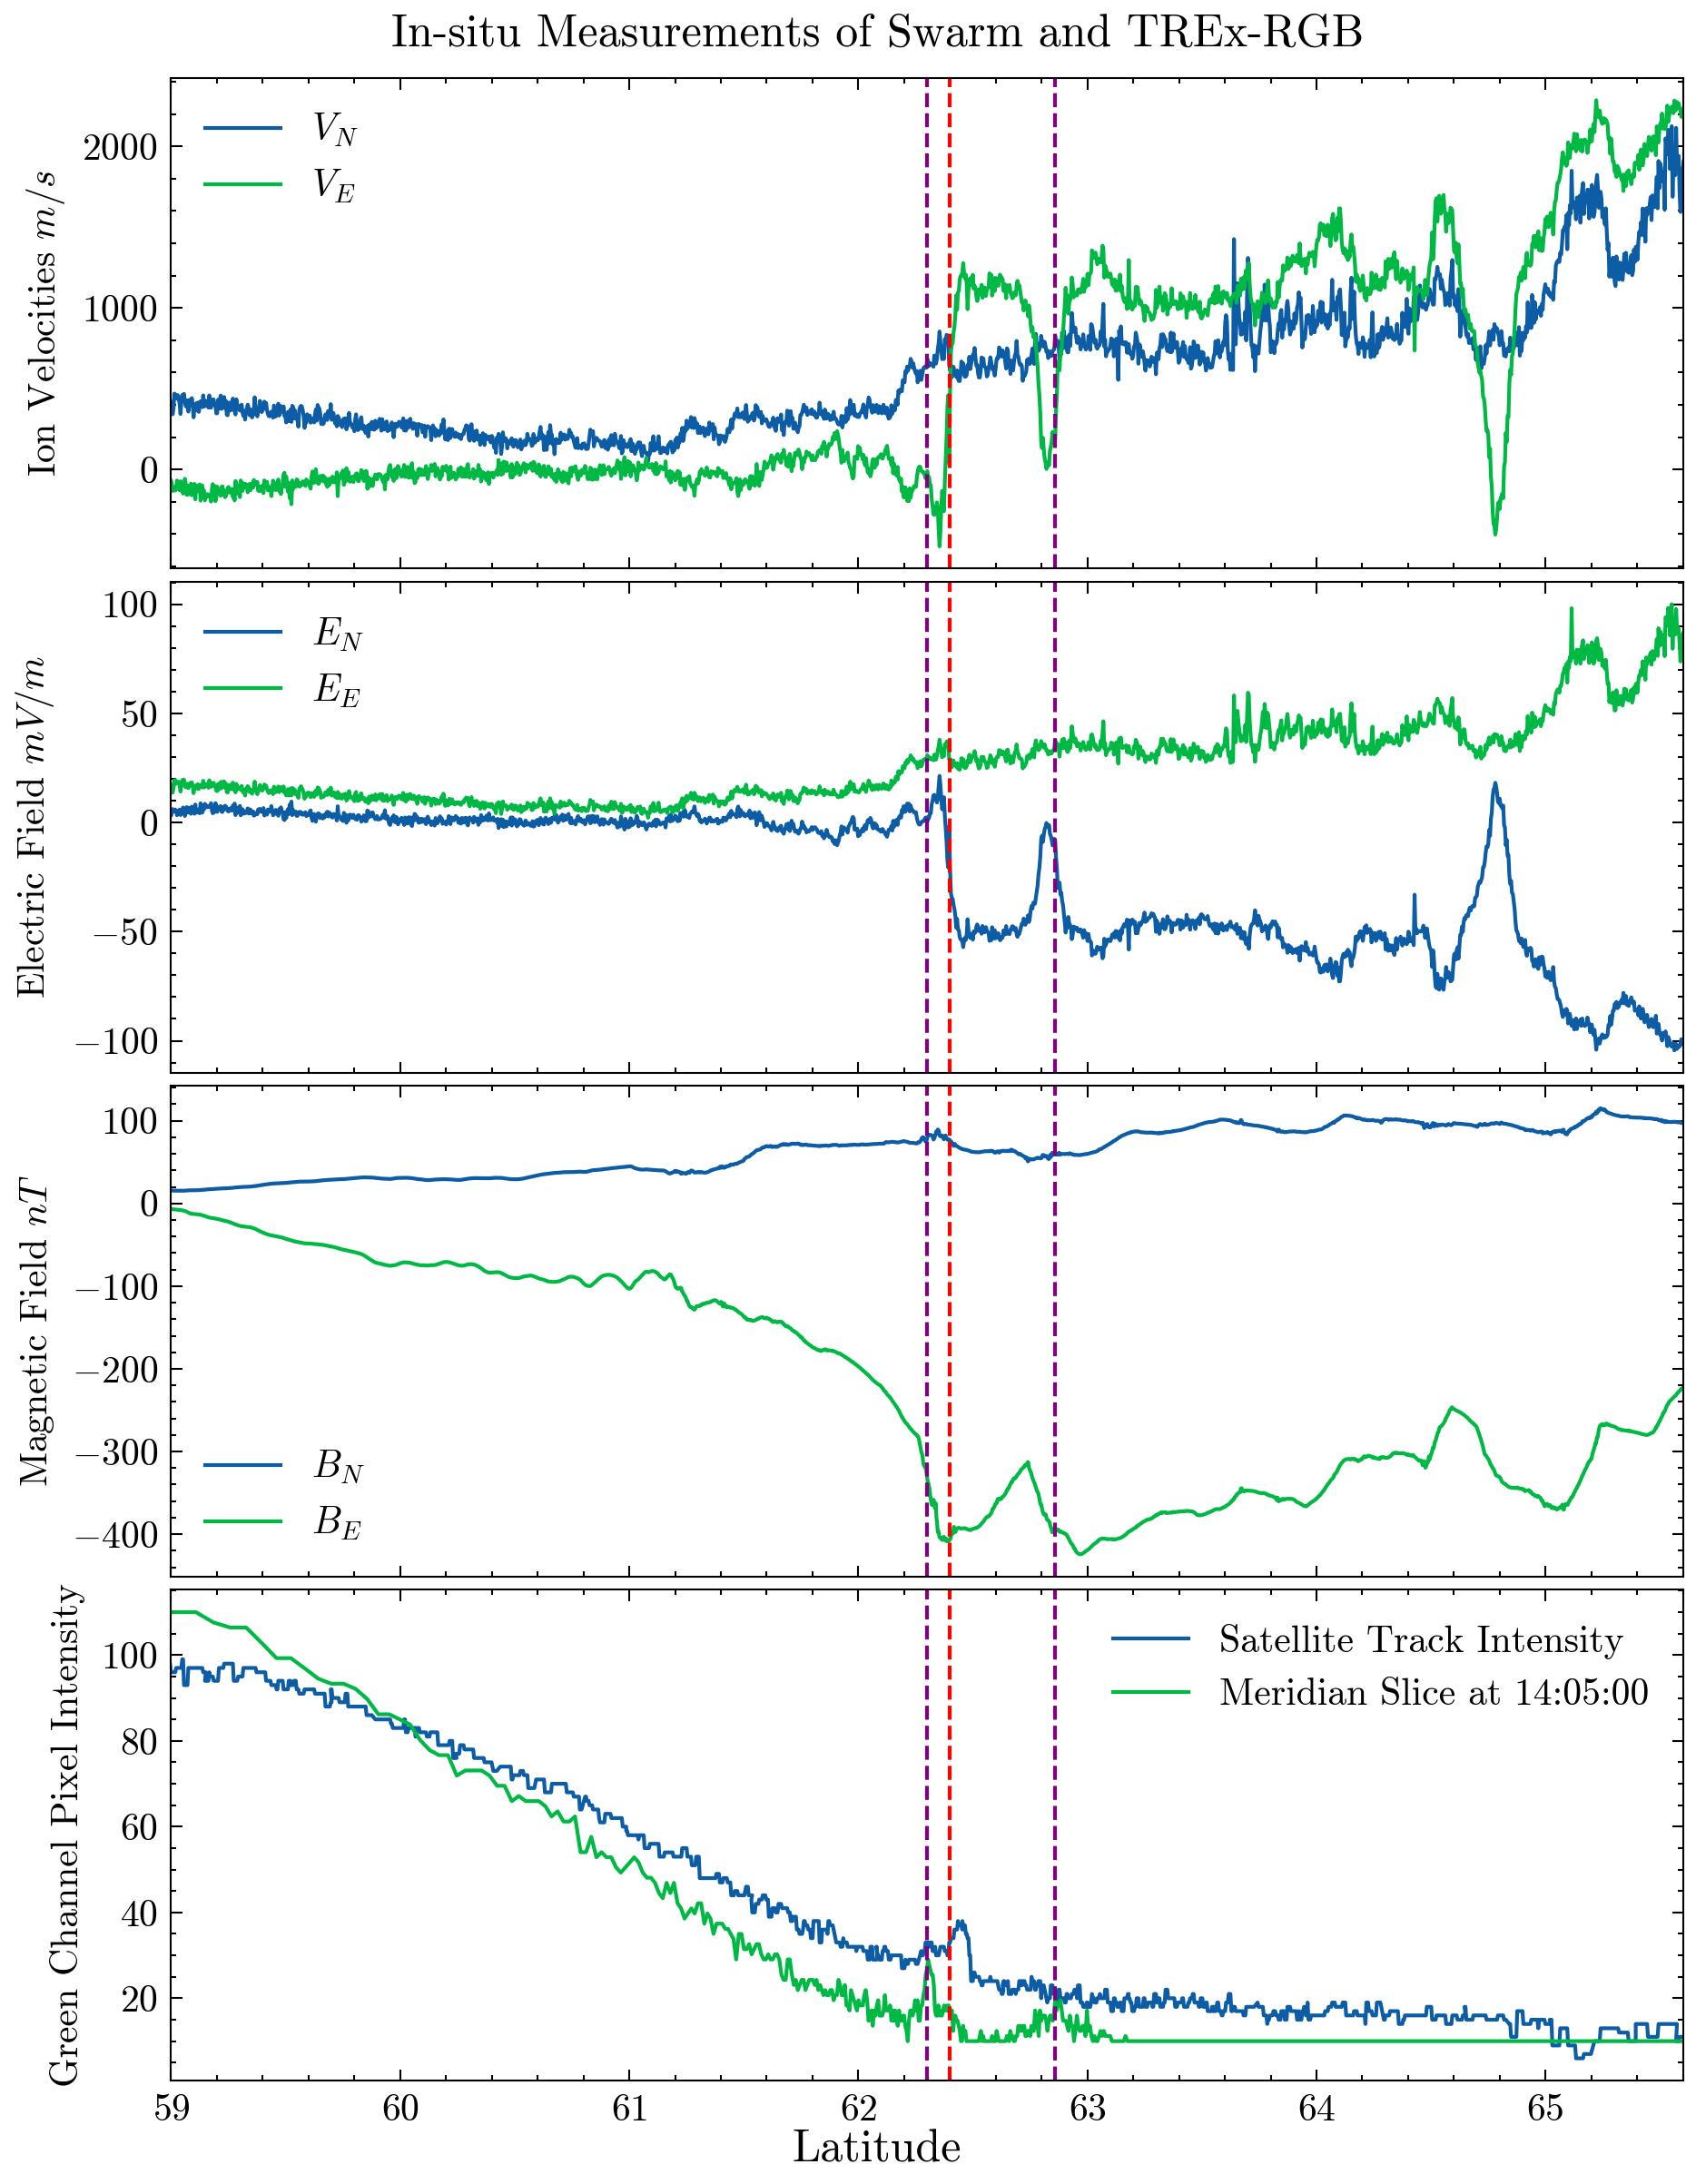

In [ ]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, VNEC[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, ENEC[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, ENEC[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,BNEC[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, BNEC[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
print()
axes[3].plot(im_good.get_coordinates()[:, 60, 1][:-1], im_good.get_array()[:, 60, 0]*100+10, label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

Doesn't line up because the arc doesnt follow magnetic latitude, its more aligned east west due to the convection flow shape

In [ ]:
import numpy as np
import datetime

# Example array of Python datetime objects
datetime_array = np.array([
    datetime.datetime(2024, 8, 10, 12, 0),
    datetime.datetime(2024, 8, 11, 12, 0),
    datetime.datetime(2024, 8, 12, 12, 0),
    datetime.datetime(2024, 8, 13, 12, 0),
    datetime.datetime(2024, 8, 14, 12, 0)
])

# Given start and end datetimes
start_datetime = datetime.datetime(2024, 8, 11, 0, 0)
end_datetime = datetime.datetime(2024, 8, 13, 0, 0)

# Find the indices where datetime_array is between start_datetime and end_datetime
indices = np.where((datetime_array >= start_datetime) & (datetime_array <= end_datetime))[0]

print(indices)

[1 2]


Now we want to do a bandpass filter for the above electrodynamics data so we can differeinate between large and small scale. We will do a variety of filters so we can choose one that looks good. We will do 0.05Hz, 0.1Hz, 0.2Hz, 0.5Hz to 6Hz

In [ ]:
from scipy.signal import butter, filtfilt

def butter_bandpass(cutoffs, fs, order=4):
    if cutoffs[0] ==0:
        return butter(order, cutoffs[1], fs=fs, btype="low")
    else:
        return butter(order, cutoffs, fs=fs, btype="band")


def butter_bandpass_filter(data, cutoffs, fs, order=4):
    b, a = butter_bandpass(cutoffs, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
V005,V01,V02,V05= np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC))), np.zeros((np.shape(VNEC)))
E005,E01,E02,E05 = np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC))), np.zeros((np.shape(ENEC)))
B005,B01,B02,B05 = np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC))), np.zeros((np.shape(BNEC)))
for i in range(3):
    V005[:, i]=butter_bandpass_filter(VNEC[:, i], [0.05, 6], 16)
    V01[:, i]=butter_bandpass_filter(VNEC[:, i], [0.1, 6], 50)
    V02[:, i]=butter_bandpass_filter(VNEC[:, i], [0.2, 6], 50)
    V05[:, i]=butter_bandpass_filter(VNEC[:, i], [0.5, 6], 50)

    E005[:, i]=butter_bandpass_filter(ENEC[:, i], [0.05, 6], 16)
    E01[:, i]=butter_bandpass_filter(ENEC[:, i], [0.1, 6], 16)
    E02[:, i]=butter_bandpass_filter(ENEC[:, i], [0.2, 6], 16)
    E05[:, i]=butter_bandpass_filter(ENEC[:, i], [0.5, 6], 16)


    B005[:, i]=butter_bandpass_filter(BNEC[:, i], [0.05, 6], 50)
    B01[:, i]=butter_bandpass_filter(BNEC[:, i], [0.1, 6], 50)
    B02[:, i]=butter_bandpass_filter(BNEC[:, i], [0.2, 6], 50)
    B05[:, i]=butter_bandpass_filter(BNEC[:, i], [0.5, 6], 50)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_23728\517856379.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

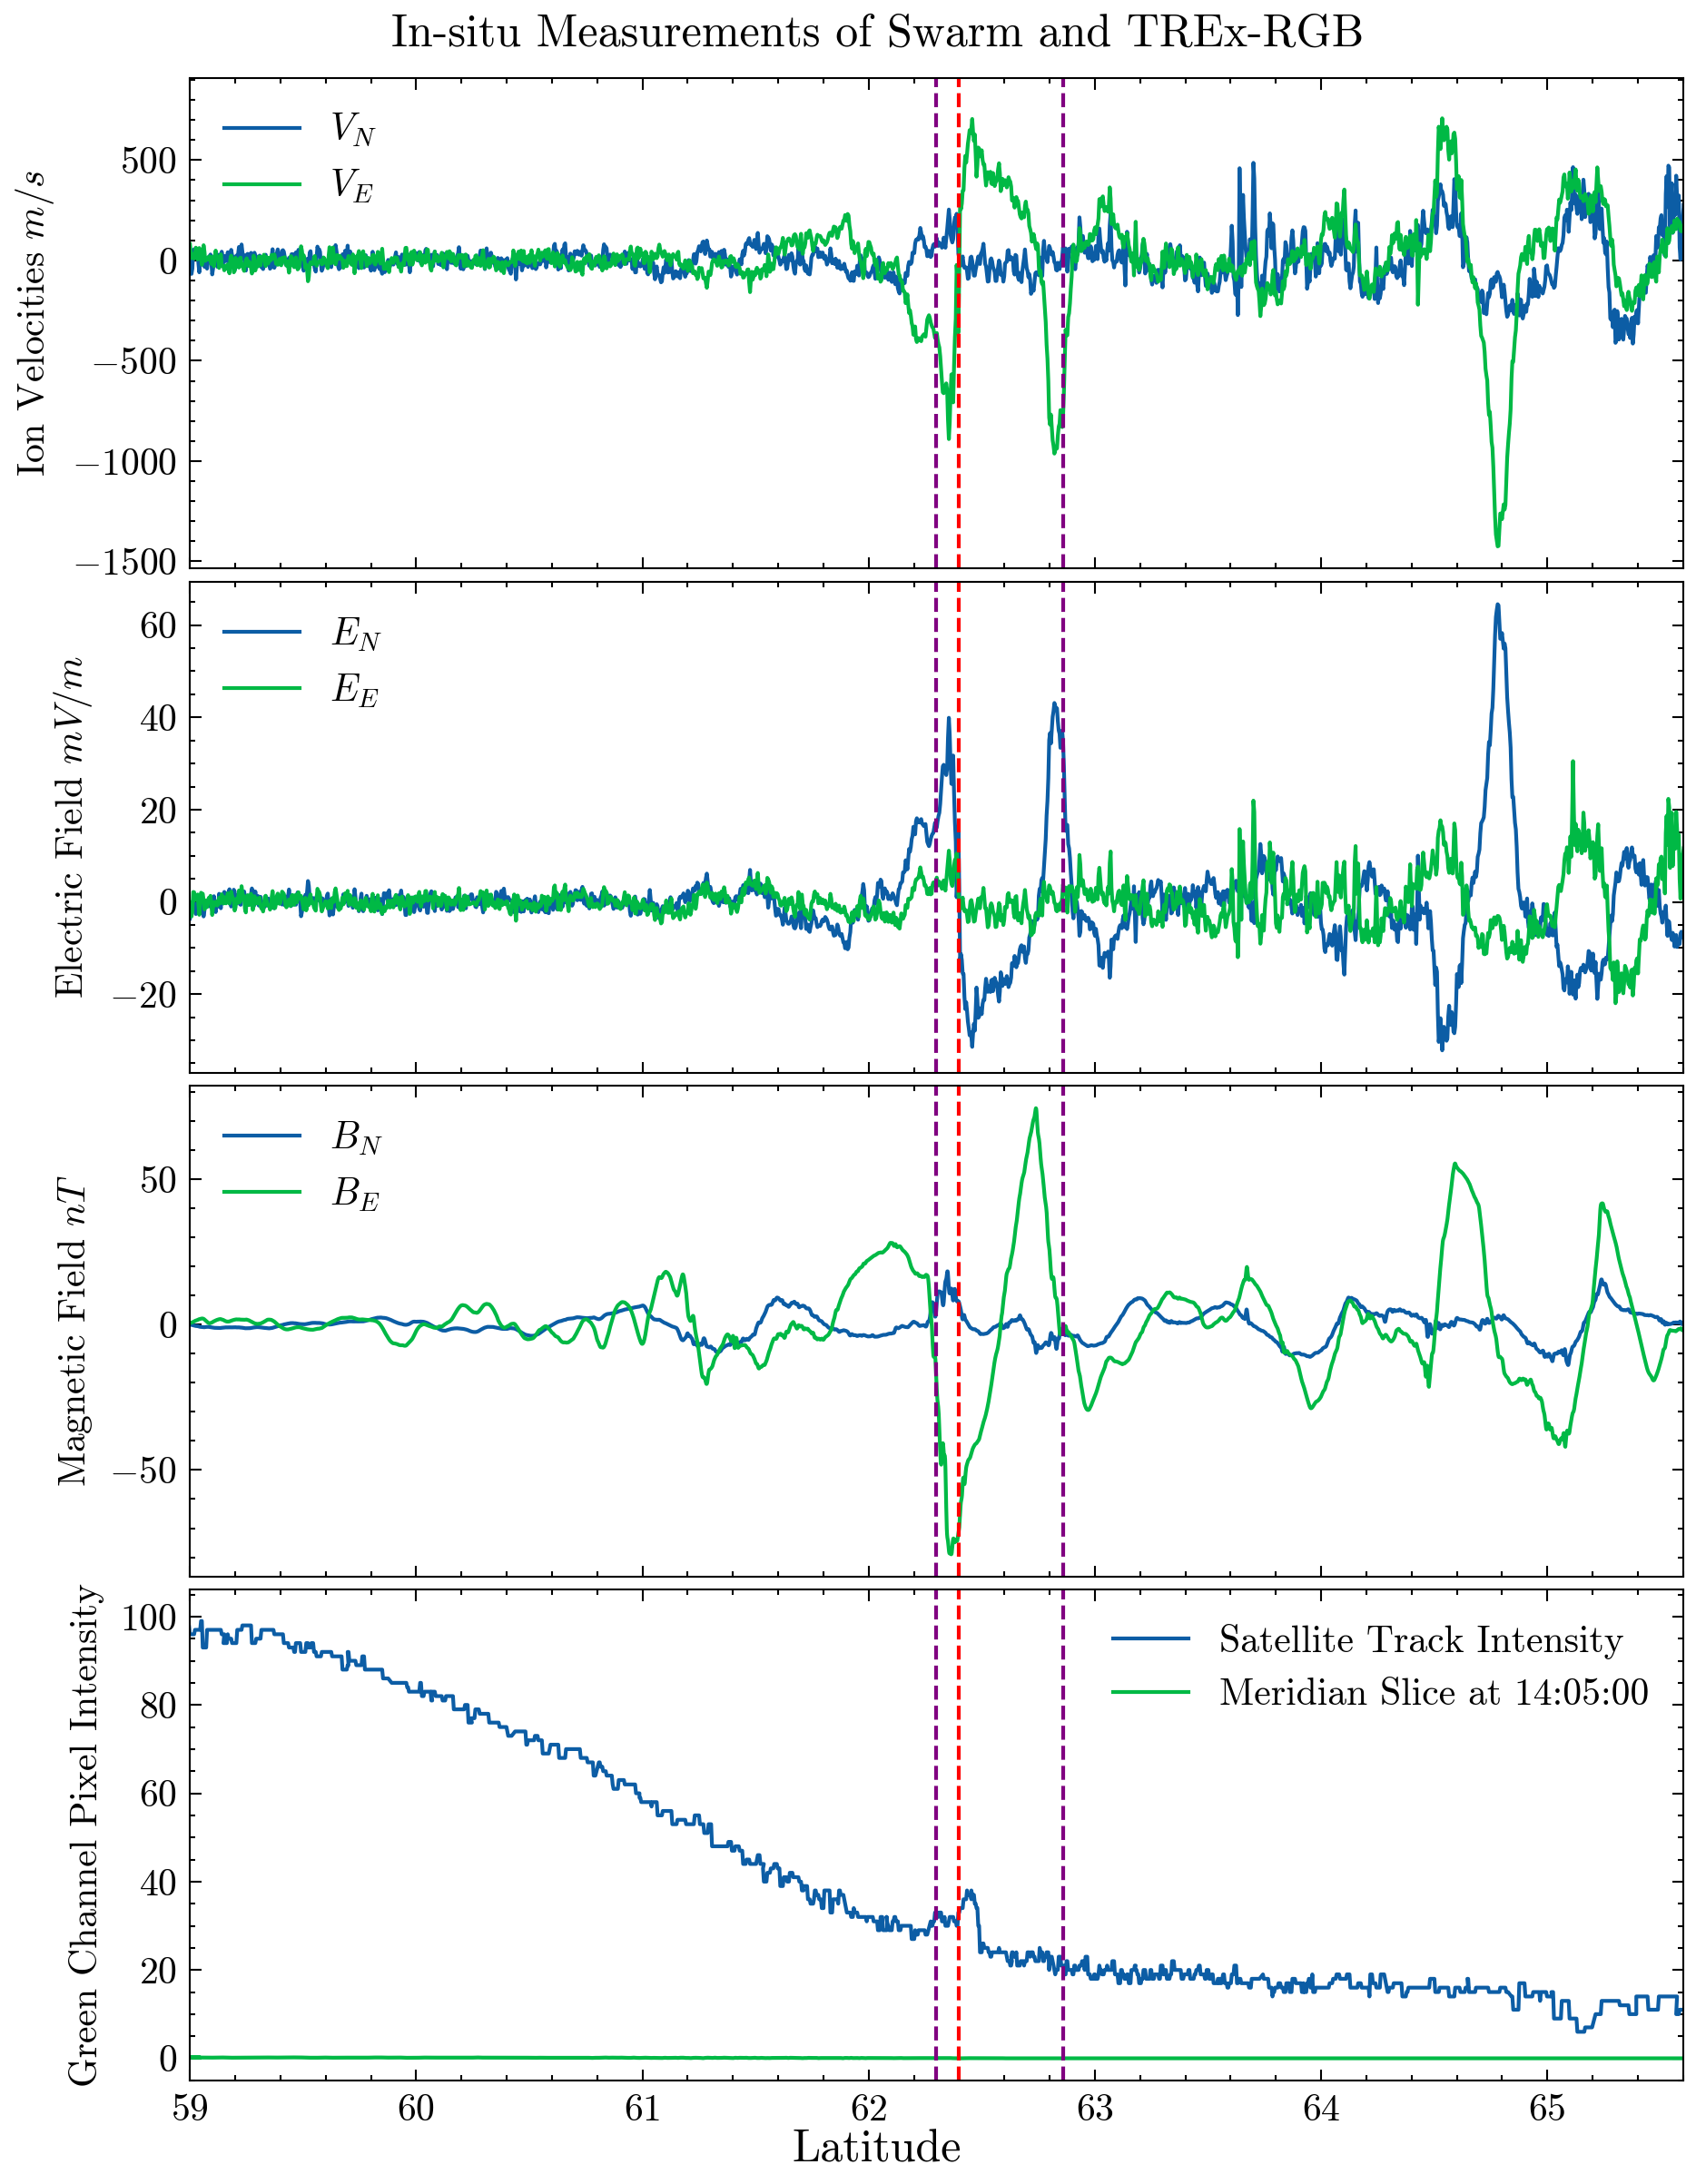

In [ ]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V005[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V005[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E005[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E005[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B005[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B005[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_23728\3546714463.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

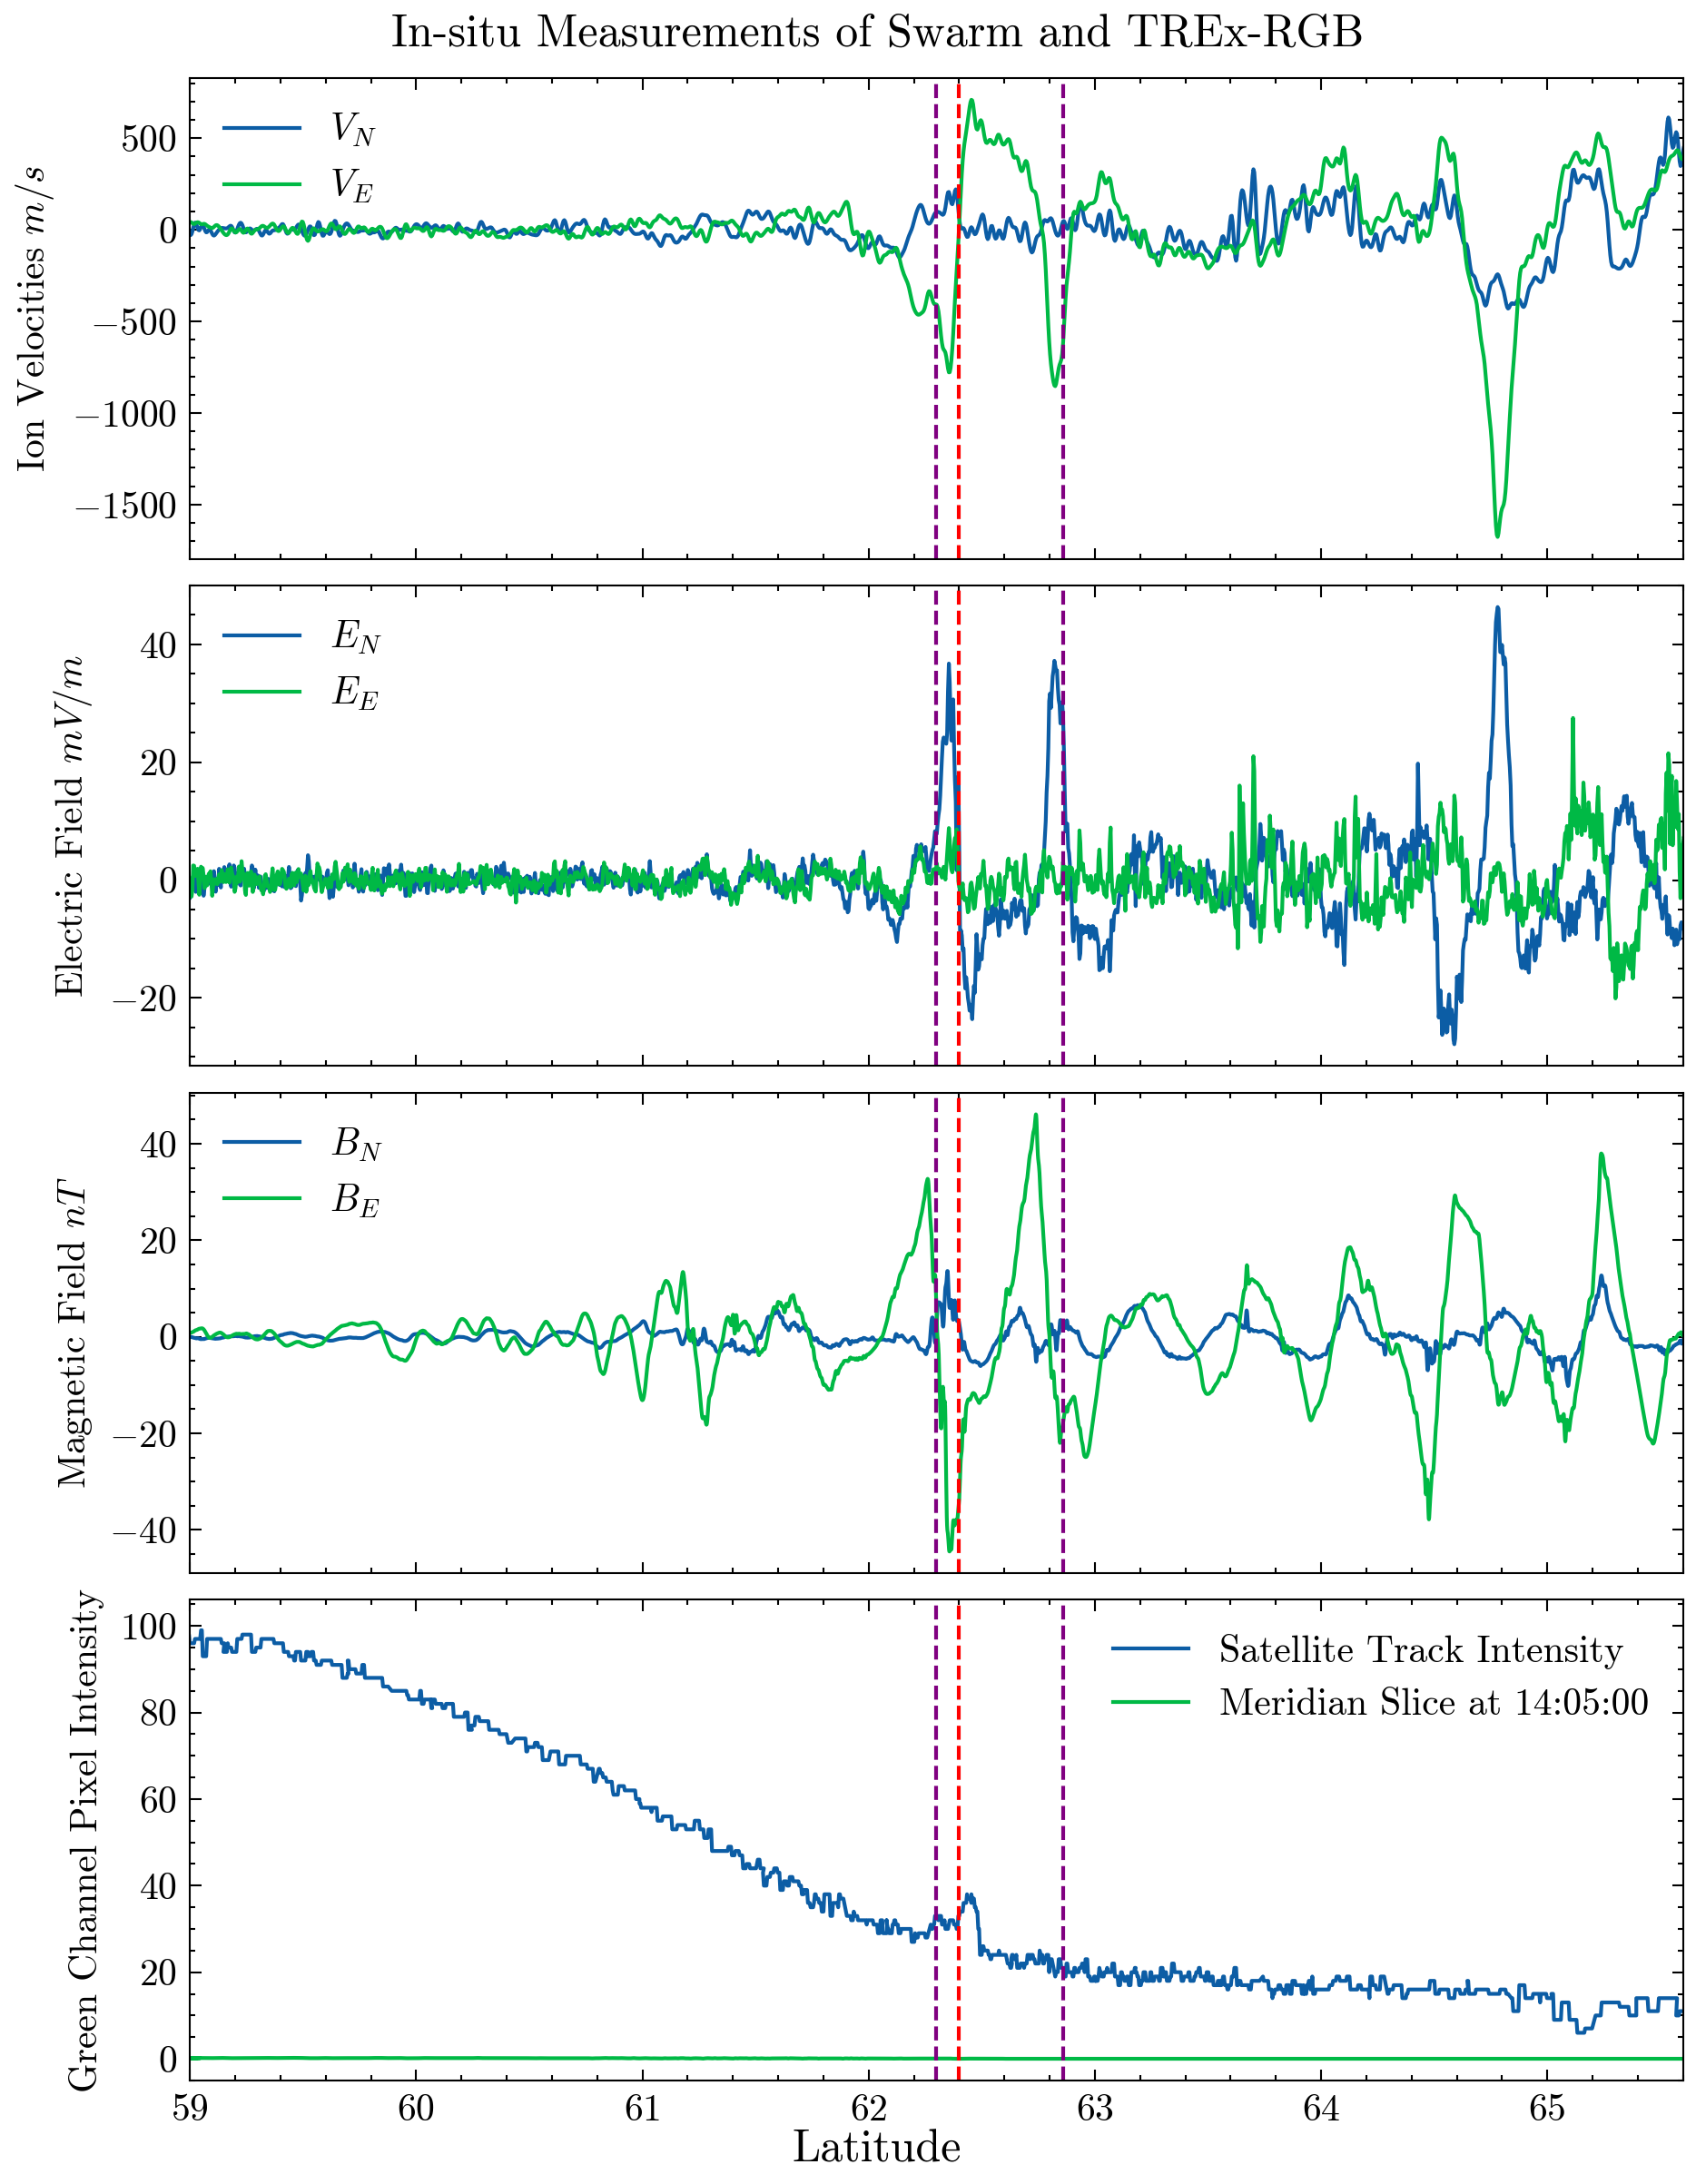

In [ ]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V01[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V01[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E01[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E01[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B01[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B01[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_23728\2505789916.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

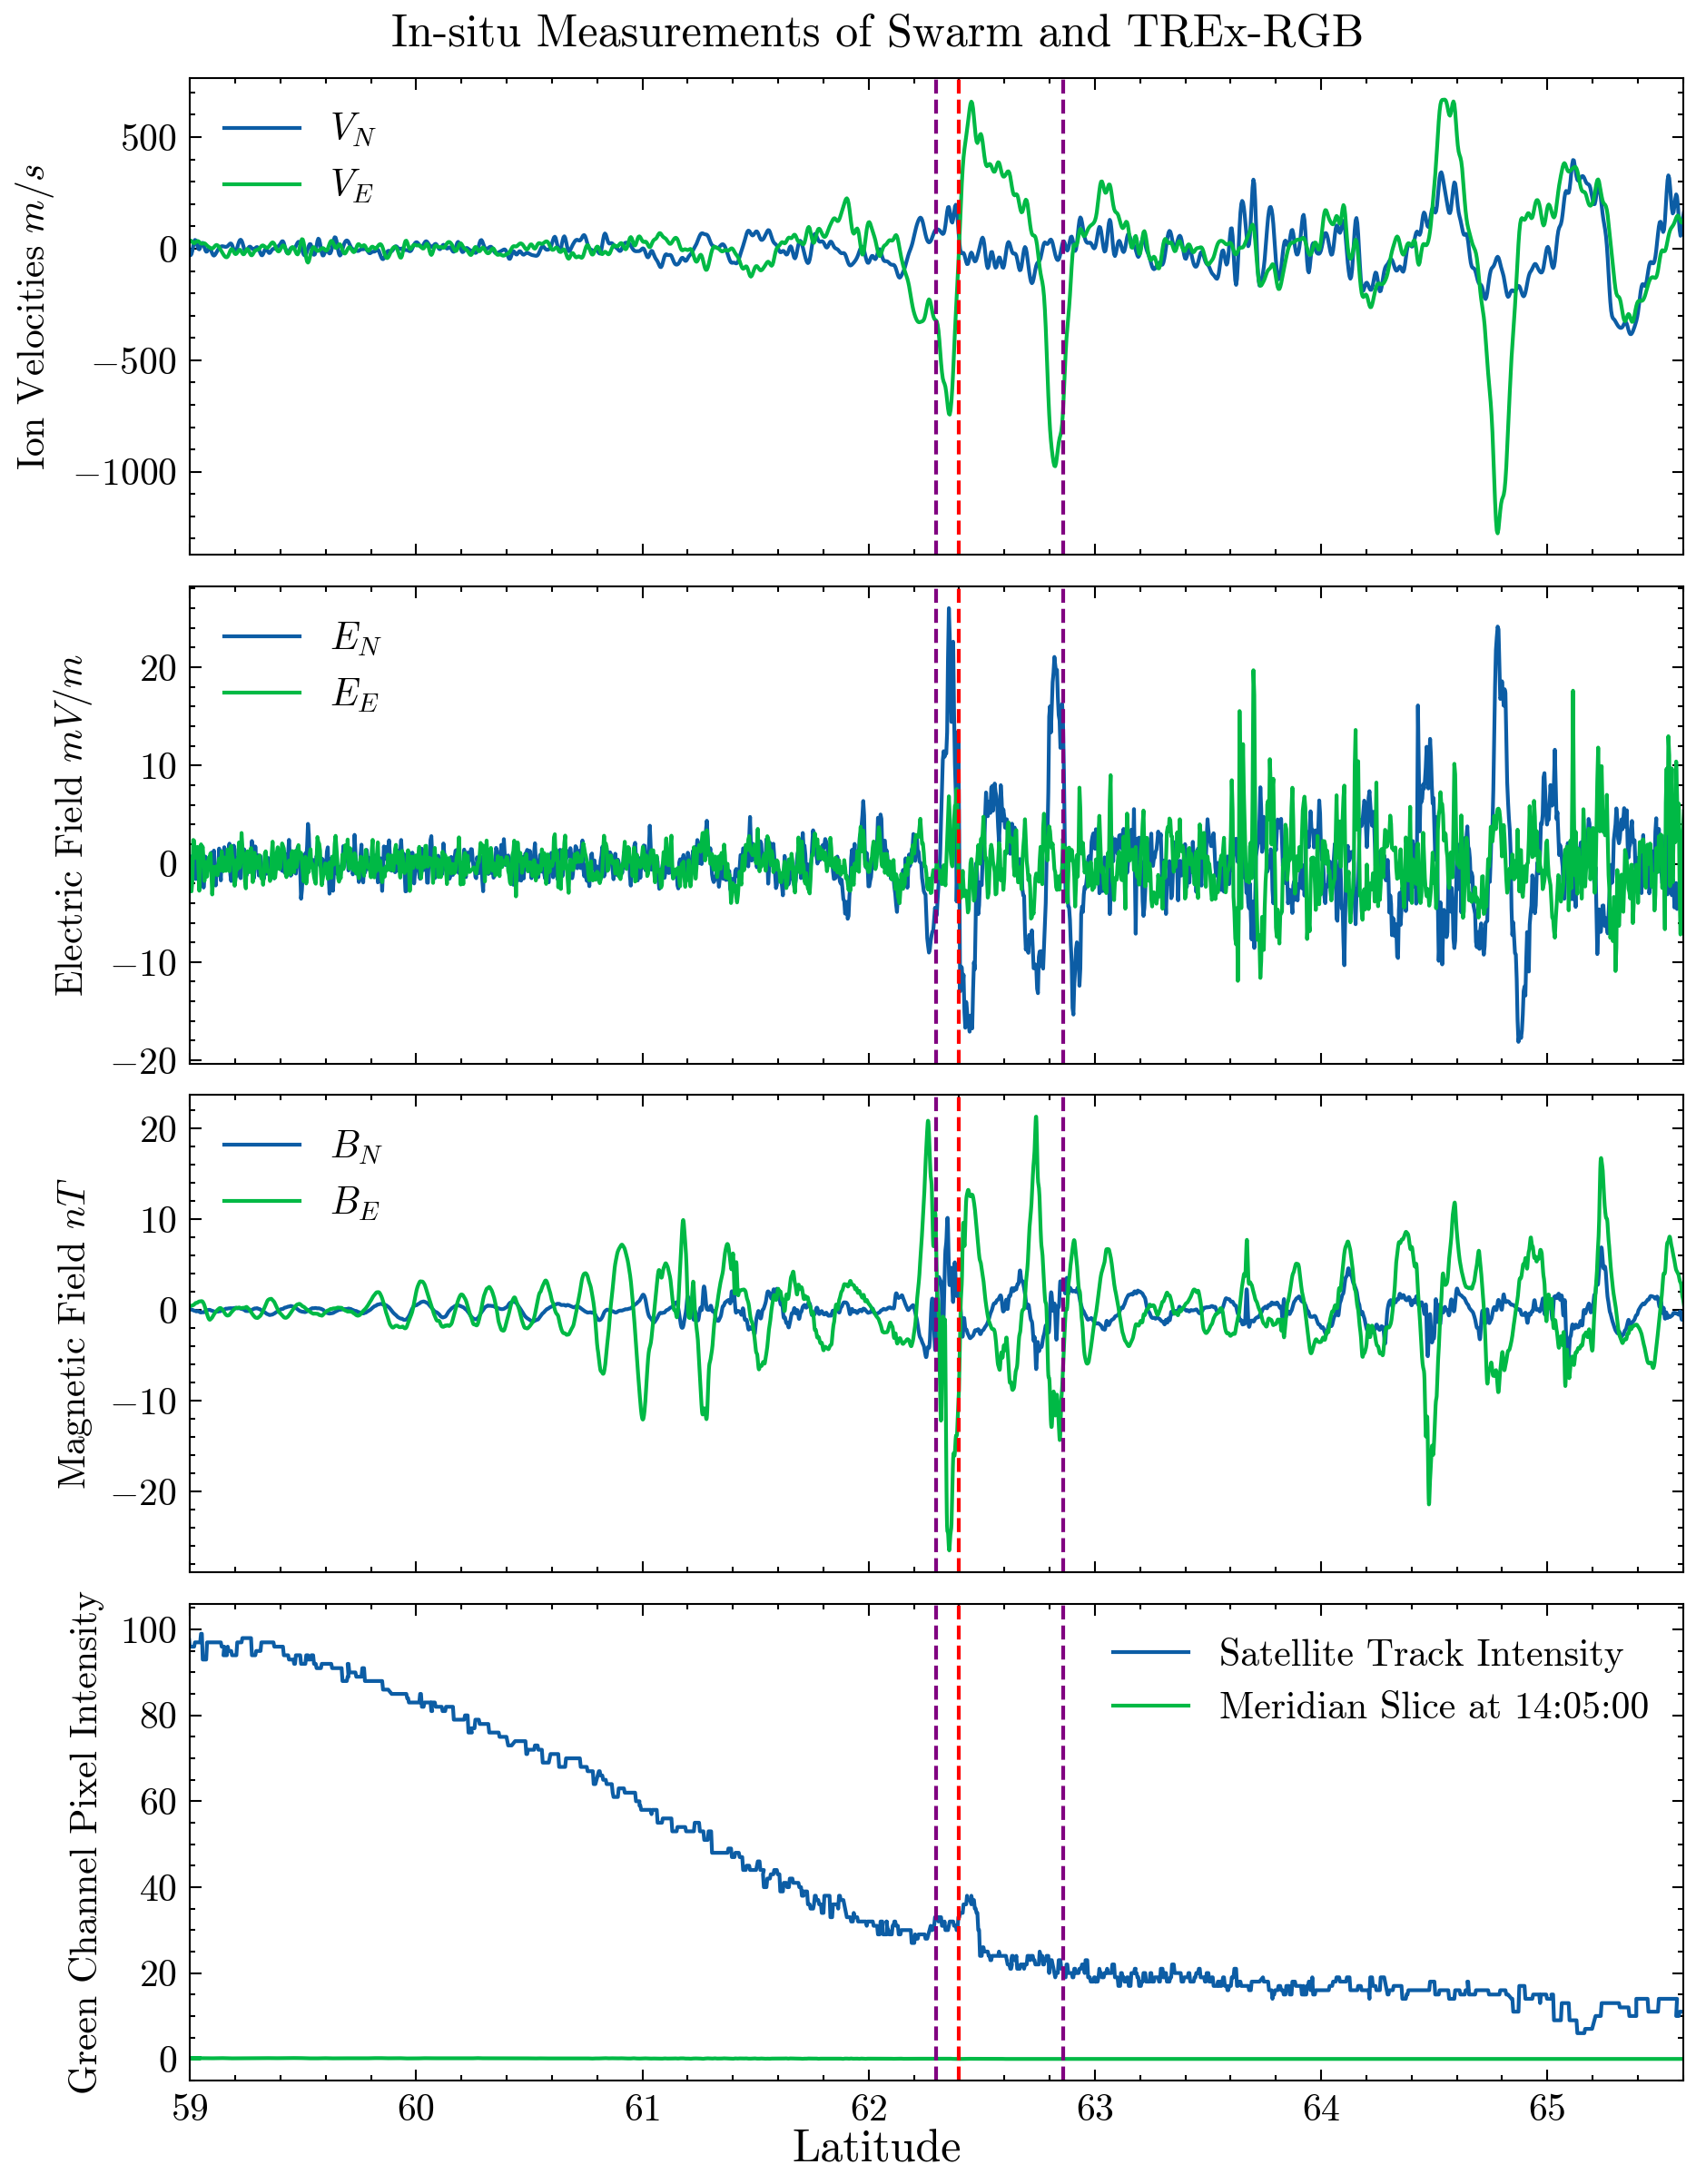

In [ ]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V02[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V02[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E02[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E02[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B02[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B02[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)

(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_23728\817563030.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

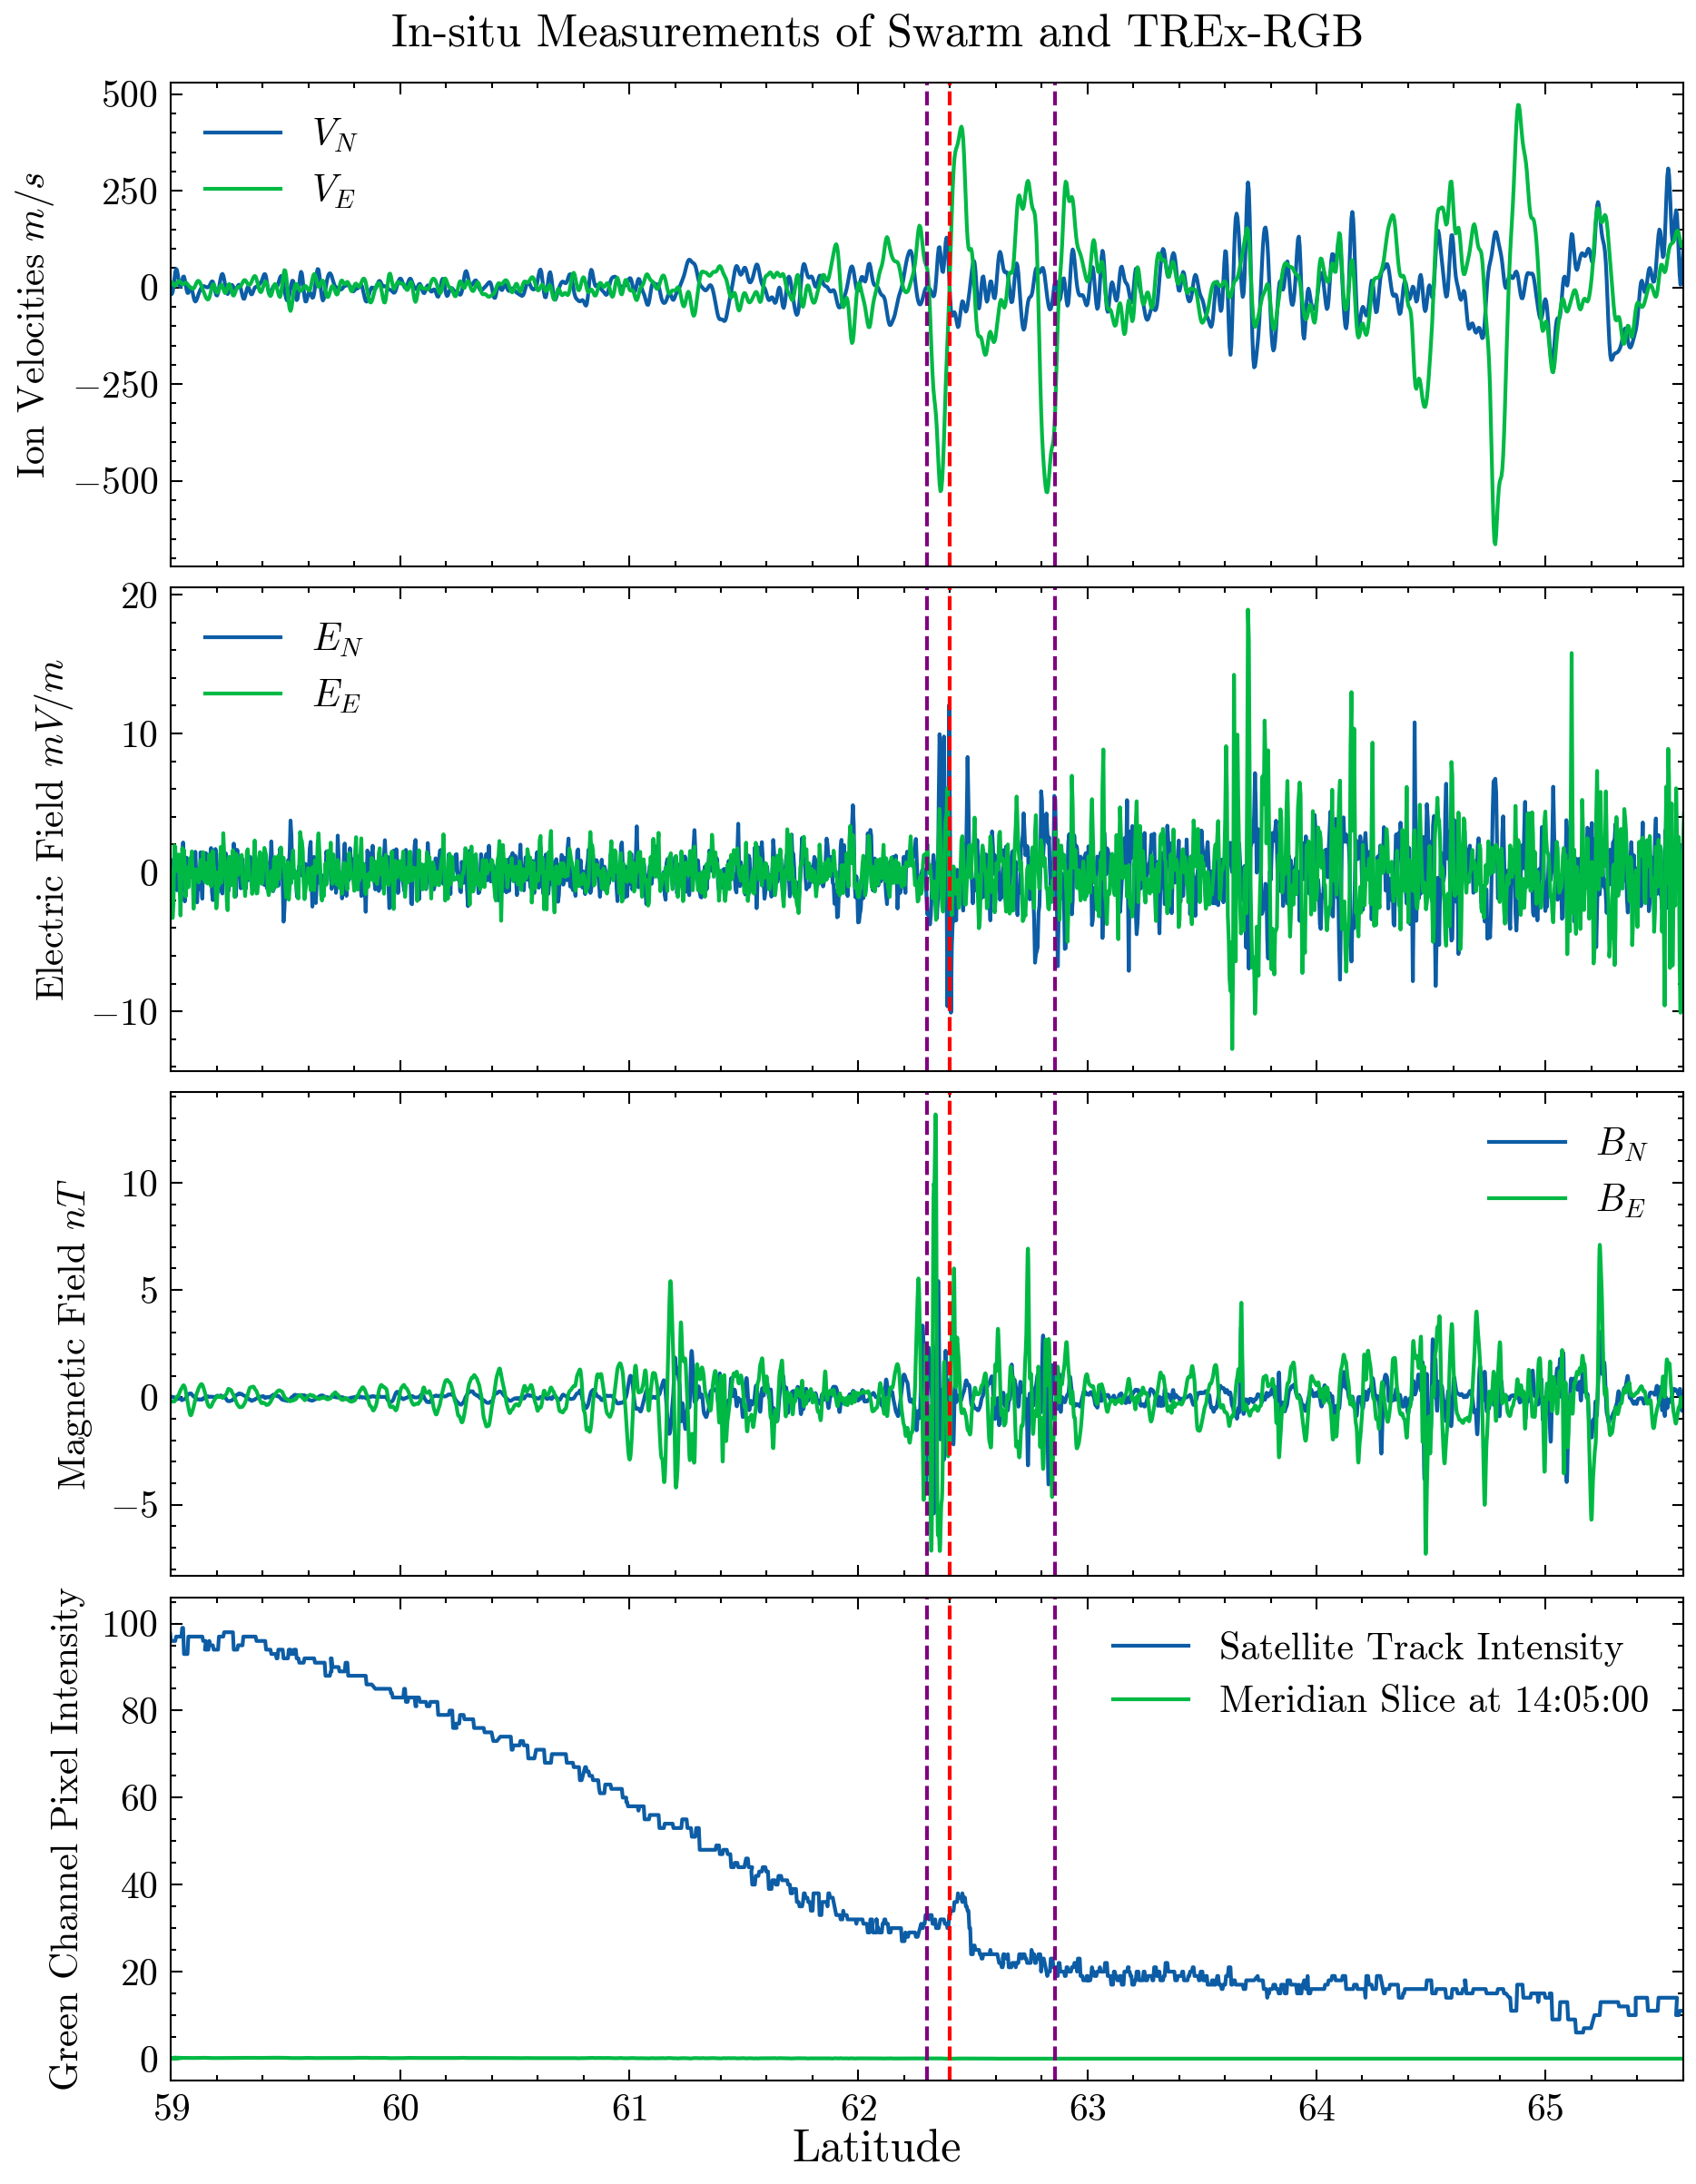

In [ ]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, V05[:,0], label=r"$V_{N}$")
axes[0].plot(lat16, V05[:, 1], label=r"$V_{E}$")
axes[1].plot(lat16, E05[:,0], label=r"$E_{N}$")
axes[1].plot(lat16, E05[:, 1], label=r"$E_{E}$")
axes[2].plot(lat50,B05[:,0], label=r"$B_{N}$")
axes[2].plot(lat50, B05[:, 1], label=r"$B_{E}$")
print(np.shape(area_intensity))
axes[3].plot(lats, pixel_chosen_array, label="Satellite Track Intensity")
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 0], label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color






axes[0].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.3, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.3, linestyle='dashed', color='purple') #change color


axes[0].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[1].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[2].axvline(62.86, linestyle='dashed', color='purple') #change color
axes[3].axvline(62.86, linestyle='dashed', color='purple') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)